In [5]:
import base64
import re # For regex to detect file paths
from typing import TypedDict, List, Literal, Union
import httpx # For fetching web images

from langchain_community.chat_models import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

# ---- STATE DEFINITION ----
# Defines the structure of the graph's state.
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        messages: A list of messages exchanged in the conversation.
                  Can contain both HumanMessage (user input) and AIMessage (agent output).
        model_choice: An optional hint for the router to explicitly select a model for the first turn.
                      This is reset after the first use to allow content-based routing.
        next_node_hint: A hint set by a routing node to guide the next transition.
    """
    messages: List[Union[HumanMessage, AIMessage]]
    model_choice: Literal["vision", "text", "code", "auto"] # 'auto' for default content-based routing
    next_node_hint: Literal["vision_handler", "text_handler", "code_handler", "llm_router_node"] # Added 'llm_router_node'


# ---- MODEL INITIALIZATION ----
# Initialize different Ollama models for specific tasks.
# Ensure these models are downloaded and available via your Ollama server.
# You can download them using: ollama pull <model_name> (e.g., ollama pull llava)
llm_text = ChatOllama(model="llama3.2")         # General text generation (also used for LLM-driven routing)
llm_vision = ChatOllama(model="gemma3")          # Reverted to gemma3 as per your request
llm_code = ChatOllama(model="qwen2.5-coder:7b")    # Code generation/understanding


# ---- HELPER FUNCTION: ENCODE LOCAL IMAGE ----
def encode_local_image(image_path: str) -> Union[str, None]:
    """
    Encodes an image file from a local path to a base64 string.

    Args:
        image_path: The local file path to the image.

    Returns:
        The base64 encoded string of the image, or None if an error occurs.
    """
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: Local image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error encoding local image: {e}")
        return None

# ---- HELPER FUNCTION: FETCH AND ENCODE WEB IMAGE ----
def fetch_and_encode_web_image(image_url: str) -> Union[str, None]:
    """
    Fetches an image from a URL and encodes it to a base64 string.

    Args:
        image_url: The URL of the image.

    Returns:
        The base64 encoded string of the image, or None if an error occurs.
    """
    try:
        response = httpx.get(image_url, follow_redirects=True, timeout=10)
        response.raise_for_status() # Raise an exception for bad status codes
        return base64.b64encode(response.content).decode("utf-8")
    except httpx.RequestError as e:
        print(f"Error fetching image from URL {image_url}: {e}")
        return None
    except Exception as e:
        print(f"Error encoding image from URL {image_url}: {e}")
        return None


# ---- GRAPH NODES ----
def text_node(state: GraphState) -> GraphState:
    """
    Processes the message using the text-capable LLM.
    Appends the AI's response to the messages list.
    """
    print("---Entering TEXT NODE---")
    response = llm_text.invoke(state["messages"])
    state["messages"].append(AIMessage(content=response.content))
    return state

def vision_node(state: GraphState) -> GraphState:
    """
    Processes the message using the vision-capable LLM.
    This node expects the message to already contain image data,
    which is handled by the preprocess_and_route_node.
    Appends the AI's response to the messages list.
    """
    print("---Entering VISION NODE---")
    # --- DEBUGGING: Print the incoming messages to verify image data ---
    #print(f"Vision Node - Incoming Messages: {state['messages']}")
    # --- END DEBUGGING ---
    response = llm_vision.invoke(state["messages"])
    state["messages"].append(AIMessage(content=response.content))
    return state

def code_node(state: GraphState) -> GraphState:
    """
    Processes the message using the code-capable LLM.
    Appends the AI's response to the messages list.
    """
    print("---Entering CODE NODE---")
    response = llm_code.invoke(state["messages"])
    state["messages"].append(AIMessage(content=response.content))
    return state


# ---- LLM-DRIVEN ROUTER NODE ----
def llm_router_node(state: GraphState) -> GraphState:
    """
    Uses the text LLM to decide the next routing path ('text', 'vision', or 'code').
    """
    print("---Entering LLM ROUTER NODE---")
    # Get the last message from the user
    # We need to ensure the LLM sees the *user's original intent*,
    # not necessarily the multimodal message if an image was processed.
    # For routing, a text-only representation might be sufficient.
    last_user_message_content = ""
    last_msg = state["messages"][-1]
    if isinstance(last_msg, HumanMessage):
        if isinstance(last_msg.content, str):
            last_user_message_content = last_msg.content
        elif isinstance(last_msg.content, list):
            # Extract text part from multimodal message for routing decision
            for part in last_msg.content:
                if isinstance(part, dict) and part.get("type") == "text":
                    last_user_message_content = part.get("text", "")
                    break

    if not last_user_message_content:
        print("No relevant text content found for LLM routing. Defaulting to text_handler.")
        state["next_node_hint"] = "text_handler"
        return state

    # Create a concise prompt for the LLM to classify the query
    routing_prompt = [
        HumanMessage(content=f"You are an intelligent router. Based on the following user query, decide if it primarily requires a 'text' model, a 'vision' model, or a 'code' model. Respond with ONLY one word: 'text', 'vision', or 'code'.\n\nUser query: {last_user_message_content}")
    ]

    # Invoke the text LLM to get the routing decision
    try:
        response = llm_text.invoke(routing_prompt)
        decision = response.content.strip().lower()
    except Exception as e:
        print(f"Error invoking LLM for routing: {e}. Defaulting to text_handler.")
        decision = "text" # Fallback in case of LLM error

    if "vision" in decision:
        state["next_node_hint"] = "vision_handler"
    elif "code" in decision:
        state["next_node_hint"] = "code_handler"
    else: # Default to text if decision is unclear or text-related
        state["next_node_hint"] = "text_handler"

    print(f"LLM Router decided next hint: {state['next_node_hint']}")
    return state


# ---- PREPROCESSING AND ROUTING NODE (Handles Local and Web Images, then passes to LLM Router) ----
def preprocess_and_route_node(state: GraphState) -> GraphState:
    """
    Preprocesses the last message (e.g., fetches/encodes images) and then
    sets the hint to either a direct handler (if explicit model_choice or image detected)
    or to the LLM router node.
    """
    print("---Entering PREPROCESS AND ROUTE NODE---")
    last_msg = state["messages"][-1]
    
    # Initialize model_choice if it's not present in the state (for the first turn)
    if "model_choice" not in state:
        state["model_choice"] = "auto"

    next_hint_from_preprocess = None # Will store the hint decided by this node

    # --- IMPORTANT CHANGE: Always attempt image preprocessing if a string message is detected ---
    # This ensures the message is in the correct multimodal format BEFORE any routing decision,
    # whether it's direct via model_choice or via LLM router.
    image_processed = False
    if isinstance(last_msg, HumanMessage) and isinstance(last_msg.content, str):
        text_content = last_msg.content

        # 1. Check for LOCAL image file paths
        local_file_path_match = re.search(
            r'(file://)?'                                 # Group 1: Optional file:// prefix
            r'('                                           # Start Group 2: The ENTIRE file path
            r'(?:[a-zA-Z]:[\\/]|[\/])'                     #   Windows drive letter + separator OR Unix root slash
            r'(?:[^<>:"|?*\\/]+\\?)*'                  #   Zero or more path segments (non-greedy, allowing trailing slash)
            r'[^<>:"|?*\\/]*'                             #   Zero or more filename characters before the dot
            r'\.'                                         #   Literal dot
            r'(jpg|jpeg|png|gif|bmp|tiff)'                #   Group 3: The file extension itself
            r')'                                           # End Group 2
            r'$',                                          # End of string anchor
            text_content,
            re.IGNORECASE # Make extension matching case-insensitive
        )

        if local_file_path_match:
            detected_path = local_file_path_match.group(2)
            image_extension = local_file_path_match.group(3)
            print(f"Detected potential local image file path: {detected_path}")
            
            base64_img = encode_local_image(detected_path)
            if base64_img:
                new_text_part = text_content.replace(local_file_path_match.group(0), "").strip() or "Describe this image:"
                new_content = [
                    {"type": "text", "text": new_text_part},
                    {"type": "image_url", "image_url": {"url": f"data:image/{image_extension};base64,{base64_img}"}},
                ]
                state["messages"][-1] = HumanMessage(content=new_content)
                image_processed = True
                print(f"Local image encoded and message updated.")
            else:
                print("Failed to encode local image.")

        # 2. Check for WEB image URLs (only if no local image was found and processed)
        if not image_processed:
            web_image_url_match = re.search(r'(https?:\/\/[^\s\/$.?#].[^\s]*?\.(jpg|jpeg|png|gif|bmp|tiff))', text_content, re.IGNORECASE)
            if web_image_url_match:
                detected_url = web_image_url_match.group(1)
                image_extension = web_image_url_match.group(2)
                print(f"Detected potential web image URL: {detected_url}")
                
                base64_img = fetch_and_encode_web_image(detected_url)
                if base64_img:
                    new_text_part = text_content.replace(web_image_url_match.group(0), "").strip() or "Describe this image:"
                    new_content = [
                        {"type": "text", "text": new_text_part},
                        {"type": "image_url", "image_url": {"url": f"data:image/{image_extension};base64,{base64_img}"}},
                    ]
                    state["messages"][-1] = HumanMessage(content=new_content)
                    image_processed = True
                    print(f"Web image encoded and message updated.")
                else:
                    print("Failed to fetch or encode web image.")
    # --- END IMPORTANT CHANGE ---

    # Now that image preprocessing is done, determine the next hint based on model_choice or LLM routing
    if state.get("model_choice") == "code":
        next_hint_from_preprocess = "code_handler"
        state["model_choice"] = "auto" # Reset to auto for next turn
    elif state.get("model_choice") == "vision":
        next_hint_from_preprocess = "vision_handler"
        state["model_choice"] = "auto" # Reset to auto for next turn
    elif image_processed: # If an image was processed, directly route to vision_handler
        next_hint_from_preprocess = "vision_handler"
        print("Image successfully processed, directly routing to VISION HANDLER.")
    else:
        # If no explicit model_choice AND no image was processed,
        # then delegate to the LLM router for text/code keyword classification.
        next_hint_from_preprocess = "llm_router_node"
        # Check for code keywords here to influence LLM router's decision if needed,
        # though the LLM router's prompt handles this.
        if isinstance(last_msg, HumanMessage) and isinstance(last_msg.content, str):
            code_keywords = ["code", "program", "function", "script", "develop", "implement", "write in",
                             "python", "javascript", "java", "c++", "html", "css", "sql", "bash"]
            if any(keyword in last_msg.content.lower() for keyword in code_keywords):
                print("Code keywords detected, routing to LLM Router for decision.")


    state["next_node_hint"] = next_hint_from_preprocess # Set the hint in the state
    print(f"Preprocess node decided next hint: {next_hint_from_preprocess}")
    return state


# ---- ROUTING DECISION FUNCTION ----
def route_decision(state: GraphState) -> Literal["vision_handler", "text_handler", "code_handler", "llm_router_node"]:
    """
    Reads the 'next_node_hint' from the state to determine the next node.
    This function is used by add_conditional_edges and only returns a string.
    """
    print(f"---Making ROUTING DECISION based on hint: {state['next_node_hint']}---")
    return state["next_node_hint"]


# ---- BUILD THE LANGGRAPH WORKFLOW ----
workflow = StateGraph(GraphState)

# Add all nodes
workflow.add_node("preprocess_and_route_node", preprocess_and_route_node)
workflow.add_node("llm_router_node", llm_router_node) # LLM router node
workflow.add_node("text_handler", text_node)
workflow.add_node("vision_handler", vision_node)
workflow.add_node("code_handler", code_node)

# Set the preprocess_and_route_node as the entry point
workflow.set_entry_point("preprocess_and_route_node")

# Add conditional edges from the preprocess_and_route_node
# This node now routes either directly to a handler (if explicit model_choice or image detected)
# or to the LLM router node for a more nuanced decision.
workflow.add_conditional_edges(
    "preprocess_and_route_node", # Source node
    route_decision,              # Function to determine next step
    {
        "text_handler": "text_handler", # This path will now only be taken by explicit model_choice
        "vision_handler": "vision_handler", # This path will now be taken by explicit model_choice OR direct image detection
        "code_handler": "code_handler",     # This path will now only be taken by explicit model_choice
        "llm_router_node": "llm_router_node" # Route to LLM router for all other cases (text, code keywords)
    }
)

# Add conditional edges from the LLM router node to the handlers
# This is where the LLM's decision takes effect.
workflow.add_conditional_edges(
    "llm_router_node", # Source node
    route_decision,    # Function to determine next step (based on LLM's hint)
    {
        "text_handler": "text_handler",
        "vision_handler": "vision_handler",
        "code_handler": "code_handler"
    }
)

# All handlers now go to END for a single turn
workflow.add_edge("text_handler", END)
workflow.add_edge("vision_handler", END)
workflow.add_edge("code_handler", END)

# Compile the graph
graph = workflow.compile()




# --- Test 6: Local Image Description Request (now directly routed) ---
# IMPORTANT: Replace 'D:\ML\AgenticAI_Projects\AgenticAI_langgraph\R.jpeg' with an actual, valid path



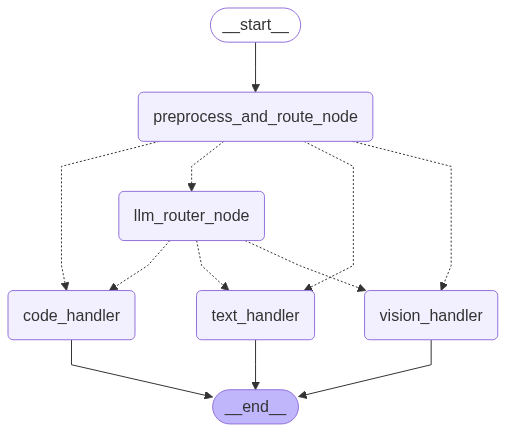

In [7]:
from IPython.display import display, Image

try:
  
    display(Image(graph.get_graph().draw_mermaid_png()))
    #graph.get_graph().draw_png("langgraph_workflow.png")
    
except Exception as e:
    print(f"\nCould not draw graph: {e}")

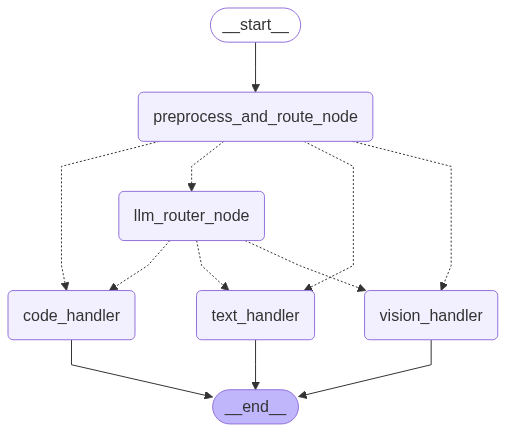

Image saved as langgraph_workflow.png


In [8]:
from IPython.display import display, Image

try:
    mermaid_png = graph.get_graph().draw_mermaid_png()
    
    # Display the image in Jupyter
    display(Image(data=mermaid_png))
    
    # Save the image to a file
    with open("langgraph_workflow.png", "wb") as f:
        f.write(mermaid_png)

    print("Image saved as langgraph_workflow.png")

except Exception as e:
    print(f"\nCould not draw graph: {e}")


In [ ]:

# # ---- TEST CASES ----
# def run_single_turn_test(name: str, input_messages: List[HumanMessage], initial_model_choice: Literal["vision", "text", "code", "auto"] = "auto"):
#     """
#     Runs a single turn test case for the Langgraph workflow.
#     """
#     print(f"\n--- Running Single Turn Test: {name} ---")
#     input_state = {
#         "messages": input_messages,
#         "model_choice": initial_model_choice,
#         "next_node_hint": "text_handler" # Default, will be overridden by preprocess_and_route_node
#     }
    
#     result = graph.invoke(input_state)
    
#     print(f"Agent Response: {result['messages'][-1].content}")
#     print(f"Total messages in conversation history: {len(result['messages'])}")


# #--- Test 1: Simple Text Query (LLM should route to text) ---
# run_single_turn_test(
#     "Simple Text Query (LLM-routed)",
#     [HumanMessage(content="What is the capital of Canada?")],
#     initial_model_choice="auto"
# )

# # --- Test 2: Code Generation Request (LLM should route to code) ---
# run_single_turn_test(
#     "Code Generation Request (LLM-routed)",
#     [HumanMessage(content="Write a Python function to calculate factorial.")],
#     initial_model_choice="auto"
# )

# # --- Test 3: Image Description Request (using a web URL - now directly routed) ---
# run_single_turn_test(
#     "Image Description Request (web URL - direct route)",
#     [HumanMessage(content="Describe the image in two lines: https://raw.githubusercontent.com/OmkarChekuri/AgenticAI_Langgraph/refs/heads/main/R.jpeg")],
#     initial_model_choice="auto"
# )

# # --- Test 4: Code Generation Request (explicit hint - direct route) ---
# run_single_turn_test(
#     "Code Generation Request (explicit hint - direct route)",
#     [HumanMessage(content="How do I print hello world in python?")],
#     initial_model_choice="code"
# )

# # --- Test 5: Image Description Request (explicit hint, another web URL - direct route) ---
# run_single_turn_test(
#     "Image Description Request (explicit hint, another web URL - direct route)",
#     [HumanMessage(content="Describe this picture in two lines: https://raw.githubusercontent.com/OmkarChekuri/AgenticAI_Langgraph/refs/heads/main/R.jpeg")],
#     initial_model_choice="vision"
# )

# # --- Test 6: Local Image Description Request (now directly routed) ---
# # IMPORTANT: Replace 'D:\ML\AgenticAI_Projects\AgenticAI_langgraph\R.jpeg' with an actual, valid path
# run_single_turn_test(
#     "Local Image Description Request (direct route)",
#     [HumanMessage(content=r"Analyze the content of this local image in two lines: D:\ML\AgenticAI_Projects\AgenticAI_langgraph\target.jpeg")],
#     initial_model_choice="auto"
# )

# # --- Test 7: Ambiguous Text Query (LLM should still route to text) ---
# run_single_turn_test(
#     "Ambiguous Text Query (LLM-routed)",
#     [HumanMessage(content="Tell me a story about a brave knight in two lines.")],
#     initial_model_choice="auto"
# )
